## Postpaid Performance : Monthly

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import datetime

## Import Data Source

In [3]:
data_src = "../Raw-Agg Perf Nationwide_Wk 2023021.csv"
df = pd.read_csv(data_src, low_memory=False)
cols = ['TM_KEY_DAY', 'TM_KEY_WK', 'TM_KEY_MTH', 'TM_KEY_YR', 'CENTER', 'METRIC_GRP', 'COMP_CD', 'PRODUCT_GRP', 'METRIC_CD', 'METRIC_NAME', 'ACTUAL_AS_OF', 'AGG_TYPE', 'RR_IND', 'GRY_IND', 'UOM', 'PERIOD', 'ACTUAL_SNAP', 'ACTUAL_AGG', 'TARGET_SNAP', 'TARGET_AGG', 'PPN_TM']
# postpaid_all_rev_cd_list = ['B2R000100', 'B2R000101', 'B2R000101', 'B2R010100', 'B2R020100']
# postpaid_dtac_rev_cd_list = ['DB2R000100', 'DB2R000101', 'DB2R000102', 'DB2R010100', 'DB2R020100']
# postpaid_tmh_rev_cd_list = ['TB2R000100', 'TB2R000101', 'TB2R000102', 'TB2R010100', 'TB2R020100']
postpaid_rev_cd_list = ['B2R000100', 'DB2R000100', 'TB2R000100']

df = df[df['TM_KEY_MTH'] <= 202305] # filter
df = df[df['METRIC_CD'].isin(postpaid_rev_cd_list)].reset_index()
df.tail(3)

,index,TM_KEY_DAY,TM_KEY_WK,TM_KEY_MTH,TM_KEY_QTR,TM_KEY_YR,DAY_DESC,MONTH_DESC,QUARTER_DESC,COMP_CD,...,SEQ,PRIORITY,REMARK,AREA_TYPE,AREA_CD,AREA_NAME,REMARK_ACTUAL,REMARK_TARGET,PPN_TM,METRIC_NAME_GROUP
273,22223,20230529,2023022,202305,20232,2023,Monday,May,Quarter 2,TRUE,...,2128.0,High,NaN,P,P,Nationwide,NaN,NaN,2023-06-02 17:46:25,Postpaid Revenue
274,22224,20230530,2023022,202305,20232,2023,Tuesday,May,Quarter 2,TRUE,...,2128.0,High,NaN,P,P,Nationwide,NaN,NaN,2023-06-02 17:46:25,Postpaid Revenue
275,22225,20230531,2023022,202305,20232,2023,Wednesday,May,Quarter 2,TRUE,...,2128.0,High,NaN,P,P,Nationwide,NaN,Bill Cycle,2023-06-02 17:46:25,Postpaid Revenue


In [4]:
# df.groupby(['CENTER', 'METRIC_GRP', 'COMP_CD', 'PRODUCT_GRP', 'METRIC_CD', 'METRIC_NAME']).size().reset_index()
df.shape

(276, 55)

## Data prep

In [ ]:
# ''' Find Metric '''
# df_metric = df.groupby(['CENTER', 'METRIC_GRP', 'COMP_CD', 'PRODUCT_GRP', 'METRIC_CD', 'METRIC_NAME']).size().reset_index()

# df_tmp = df_metric[df_metric['PRODUCT_GRP']=="Postpaid"]
# df_tmp = df_tmp[df_tmp['METRIC_GRP']=="Revenue"]
# df_tmp = df_tmp[df_tmp['METRIC_NAME'].str.contains("Revenue")].reset_index()
# df_tmp = df_tmp[df_tmp['COMP_CD']=="TRUE"]

# df_tmp

In [5]:
''' Function : Unit Million Baht '''
def unit_mb(baht):
    n = baht
    unit_mb = n / 1000000
    return unit_mb

''' Modify '''
df.loc[:, 'ACTUAL_SNAP'] = unit_mb(df['ACTUAL_SNAP'])
df.loc[:, 'ACTUAL_AGG'] = unit_mb(df['ACTUAL_AGG'])
df.loc[:, 'TARGET_SNAP'] = unit_mb(df['TARGET_SNAP'])
df.loc[:, 'TARGET_AGG'] = unit_mb(df['TARGET_AGG'])
df['MTH_DESC'] = pd.to_datetime(df['TM_KEY_MTH'], format='%Y%m', errors='coerce').dt.strftime('%B')

''' Datetime values '''
curr_yr = max(df['TM_KEY_YR'])
last_yr = max(df['TM_KEY_YR'])-1
curr_mth = max(df['TM_KEY_MTH'])
curr_mth_desc = pd.to_datetime(curr_mth, format='%Y%m', errors='coerce').strftime('%B')
last_mth = int(f'{str(last_yr)}01') if str(curr_mth)[4:]=='01' else curr_mth-1
curr_wk = max(df['TM_KEY_WK'])
curr_day = max(df['TM_KEY_DAY'])
last_ppn_tm = max(df['PPN_TM'])

# df.tail(3)

In [6]:
''' Revenue Rawdata '''
# df_rev = df.loc[:, ['TM_KEY_DAY', 'TM_KEY_WK', 'TM_KEY_MTH', 'METRIC_CD', 'METRIC_NAME', 'ACTUAL_SNAP', 'ACTUAL_AGG', 'TARGET_SNAP', 'TARGET_AGG', 'MTH_DESC']]
# df_rev.tail(3)

''' Pivot Actual by Operator '''
df_rev_act_pivot = df.pivot(index=['TM_KEY_DAY', 'TM_KEY_WK', 'TM_KEY_MTH', 'MTH_DESC'], columns=['METRIC_NAME'], values='ACTUAL_SNAP').reset_index()
df_rev_act_pivot.rename(columns=({'Postpaid Revenue': 'ALL_ACTUAL', 'Postpaid Revenue : DTAC': 'DTAC_ACTUAL', 'Postpaid Revenue : TMH': 'TMH_ACTUAL'}), inplace=True)

''' Pivot Target by Operator '''
df_rev_tgt_pivot = df.pivot(index='TM_KEY_DAY', columns='METRIC_NAME', values='TARGET_SNAP').reset_index()
df_rev_tgt_pivot.rename(columns=({'Postpaid Revenue': 'ALL_TARGET', 'Postpaid Revenue : DTAC': 'DTAC_TARGET', 'Postpaid Revenue : TMH': 'TMH_TARGET'}), inplace=True)

''' Aggregation '''
df_rev_pivot_agg = pd.merge(df_rev_act_pivot, df_rev_tgt_pivot, on='TM_KEY_DAY')
df_rev_pivot_agg['WK_LABEL'] = df_rev_pivot_agg['TM_KEY_WK'].apply(str).str[5:].astype(int)
df_rev_pivot_agg['DAY_LABEL'] = df_rev_pivot_agg['TM_KEY_DAY'].apply(str).str[6:].astype(int)
df_rev_pivot_agg.tail(3)

METRIC_NAME,TM_KEY_DAY,TM_KEY_WK,TM_KEY_MTH,MTH_DESC,ALL_ACTUAL,DTAC_ACTUAL,TMH_ACTUAL,ALL_TARGET,DTAC_TARGET,TMH_TARGET,WK_LABEL,DAY_LABEL
89,20230529,2023022,202305,May,NaN,299.939625,NaN,NaN,297.845771,NaN,22,29
90,20230530,2023022,202305,May,NaN,5.425468,NaN,NaN,6.257245,NaN,22,30
91,20230531,2023022,202305,May,NaN,6.165306,NaN,NaN,6.174819,NaN,22,31


## Monthly Performance Aggregation

In [7]:
''' Rawdata by month '''
df_rev_mth = df_rev_pivot_agg.groupby(['TM_KEY_MTH', 'MTH_DESC']).sum(numeric_only=True)[['ALL_ACTUAL', 'DTAC_ACTUAL', 'TMH_ACTUAL', 'ALL_TARGET', 'DTAC_TARGET', 'TMH_TARGET']].reset_index()

''' Aggregation '''
df_rev_mth['%ACHIEVE_ALL'] = (df_rev_mth['ALL_ACTUAL'] / df_rev_mth['ALL_TARGET'])
df_rev_mth['%ACHIEVE_DTAC'] = (df_rev_mth['DTAC_ACTUAL'] / df_rev_mth['DTAC_TARGET'])
df_rev_mth['%ACHIEVE_TMH'] = (df_rev_mth['TMH_ACTUAL'] / df_rev_mth['TMH_TARGET'])
df_rev_mth['GAP_ALL'] = df_rev_mth['ALL_ACTUAL'] - df_rev_mth['ALL_TARGET']
df_rev_mth['GAP_DTAC'] = df_rev_mth['DTAC_ACTUAL'] - df_rev_mth['DTAC_TARGET']
df_rev_mth['GAP_TMH'] = df_rev_mth['TMH_ACTUAL'] - df_rev_mth['TMH_TARGET']
df_rev_mth['DIFF_ALL'] = df_rev_mth['ALL_ACTUAL'].diff()
df_rev_mth['DIFF_DTAC'] = df_rev_mth['DTAC_ACTUAL'].diff()
df_rev_mth['DIFF_TMH'] = df_rev_mth['TMH_ACTUAL'].diff()
df_rev_mth['LAST_ACTUAL_ALL'] = df_rev_mth['ALL_ACTUAL'] - df_rev_mth['DIFF_ALL']
df_rev_mth['LAST_ACTUAL_DTAC'] = df_rev_mth['DTAC_ACTUAL'] - df_rev_mth['DIFF_DTAC']
df_rev_mth['LAST_ACTUAL_TMH'] = df_rev_mth['TMH_ACTUAL'] - df_rev_mth['DIFF_TMH']
df_rev_mth['%MOM_ALL'] = (df_rev_mth['ALL_ACTUAL'] / df_rev_mth['LAST_ACTUAL_ALL']) - 1
df_rev_mth['%MOM_DTAC'] = (df_rev_mth['DTAC_ACTUAL'] / df_rev_mth['LAST_ACTUAL_DTAC']) - 1
df_rev_mth['%MOM_TMH'] = (df_rev_mth['TMH_ACTUAL'] / df_rev_mth['LAST_ACTUAL_TMH']) - 1

''' Chart values '''
x = df_rev_mth['MTH_DESC']
x_axis = np.arange(len(x))

y_act_all = df_rev_mth['ALL_ACTUAL'].round(2)
y_act_dtac = df_rev_mth['DTAC_ACTUAL'].round(2)
y_act_tmh = df_rev_mth['TMH_ACTUAL'].round(2)
y_tgt_all = df_rev_mth['ALL_TARGET'].round(2)
y_tgt_dtac = df_rev_mth['DTAC_TARGET'].round(2)
y_tgt_tmh = df_rev_mth['TMH_TARGET'].round(2)
y_ach_all = df_rev_mth['%ACHIEVE_ALL']
y_ach_dtac = df_rev_mth['%ACHIEVE_DTAC']
y_ach_tmh = df_rev_mth['%ACHIEVE_TMH']
y_diff_all = df_rev_mth['DIFF_ALL'].round(2)
y_diff_dtac = df_rev_mth['DIFF_DTAC'].round(2)
y_diff_tmh = df_rev_mth['DIFF_TMH'].round(2)
y_last_act_all = df_rev_mth['LAST_ACTUAL_ALL'].round(2)
y_last_act_dtac = df_rev_mth['LAST_ACTUAL_DTAC'].round(2)
y_last_act_tmh = df_rev_mth['LAST_ACTUAL_TMH'].round(2)
y_mom_all = df_rev_mth['%MOM_ALL']
y_mom_dtac = df_rev_mth['%MOM_DTAC']
y_mom_tmh = df_rev_mth['%MOM_TMH']

df_rev_mth

METRIC_NAME,TM_KEY_MTH,MTH_DESC,ALL_ACTUAL,DTAC_ACTUAL,TMH_ACTUAL,ALL_TARGET,DTAC_TARGET,TMH_TARGET,%ACHIEVE_ALL,%ACHIEVE_DTAC,...,GAP_TMH,DIFF_ALL,DIFF_DTAC,DIFF_TMH,LAST_ACTUAL_ALL,LAST_ACTUAL_DTAC,LAST_ACTUAL_TMH,%MOM_ALL,%MOM_DTAC,%MOM_TMH
0,202303,March,6603.140796,2983.888468,3619.252328,6662.429193,3030.458091,3631.971102,0.991101,0.984633,...,-12.718774,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,202304,April,6654.114487,2960.554432,3693.560055,6672.685694,3030.706950,3641.978744,0.997217,0.976853,...,51.581311,50.973691,-23.334036,74.307727,6603.140796,2983.888468,3619.252328,0.007720,-0.007820,0.020531
2,202305,May,6263.814033,2953.069229,3622.275203,6300.309168,2976.157341,3634.429662,0.994207,0.992242,...,-12.154459,-390.300454,-7.485203,-71.284852,6654.114487,2960.554432,3693.560055,-0.058656,-0.002528,-0.019300


## Postpaid Revenue Summary Chart

/var/folders/4k/rll8vh6907l11_74m6bygwlc0000gn/T/ipykernel_2982/889380074.py:6: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax1 = plt.subplot(gs[:, 0])
/var/folders/4k/rll8vh6907l11_74m6bygwlc0000gn/T/ipykernel_2982/889380074.py:7: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax2 = plt.subplot(gs[:, 1:])


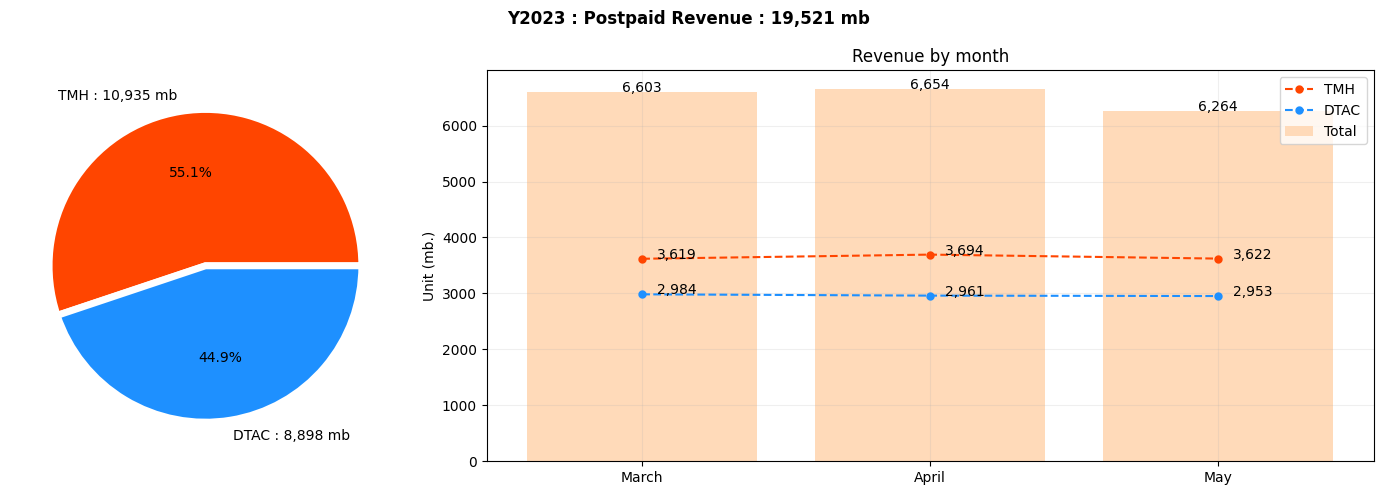

In [8]:
''' Revenue Summary Chart '''
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(14, 5))
fig.suptitle(f"Y{curr_yr} : Postpaid Revenue : {format(sum(y_act_all),',.0f')} mb", weight='bold')

gs = GridSpec(1, 3)
ax1 = plt.subplot(gs[:, 0])
ax2 = plt.subplot(gs[:, 1:])

''' ax1 '''
y = np.array([sum(y_act_tmh), sum(y_act_dtac)])
mylabels = [f"TMH : {format(y[0],',.0f')} mb", f"DTAC : {format(y[1],',.0f')} mb"]
mycolors = ["orangered", "dodgerblue"]
ax1.pie(y, labels=mylabels, colors=mycolors, autopct='%1.1f%%', wedgeprops = {"linewidth": 5, "edgecolor": "white"})

''' ax2 '''
ax2.set_title('Revenue by month')
ax2.bar(x, y_act_all, label='Total', color='peachpuff')
ax2.plot(x, y_act_tmh, marker='.', linestyle='dashed', markeredgewidth=3, label='TMH', color='orangered')
ax2.plot(x, y_act_dtac, marker='.', linestyle='dashed', markeredgewidth=3, label='DTAC', color='dodgerblue')
for i in x_axis:
    ax2.annotate(str(format(y_act_all[i],',.0f')), xy=(x_axis[i], y_act_all[i]), ha='center')
    ax2.annotate(str(format(y_act_tmh[i],',.0f')), xy=(x_axis[i]+0.05, y_act_tmh[i]))
    ax2.annotate(str(format(y_act_dtac[i],',.0f')), xy=(x_axis[i]+0.05, y_act_dtac[i]))
ax2.set_ylabel('Unit (mb.)', fontsize=10)
ax2.grid(alpha=0.2)
ax2.legend()

fig.tight_layout()
plt.show()

## Postpaid Performance Chart

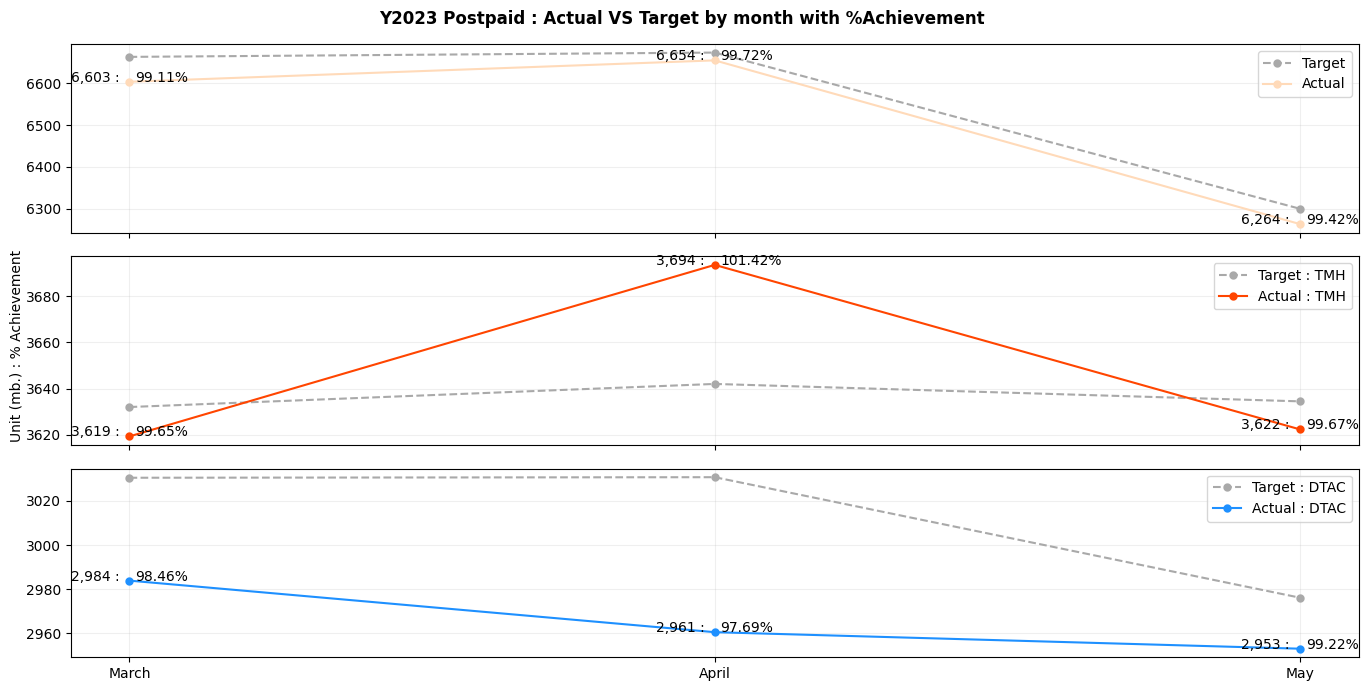

In [9]:
''' Peformance Chart '''
fig, (ax1, ax2, ax3) = plt.subplots(3, sharex=True, figsize=(14, 7))
fig.suptitle(f'Y{curr_yr} Postpaid : Actual VS Target by month with %Achievement', weight='bold')

''' ax1 '''
ax1.plot(x, y_tgt_all, marker='.', linestyle='dashed', markeredgewidth=3, label='Target', color='darkgray')
ax1.plot(x, y_act_all, marker='.', markeredgewidth=3, label='Actual', color='peachpuff')
ax1.legend()
ax1.grid(alpha=0.2)
for i in x_axis:
    ax1.annotate(str(format(y_act_all[i],',.0f'))+' :', xy=(x_axis[i]-0.1, y_act_all[i]))
    ax1.annotate(str(format(y_ach_all[i],',.2%')), xy=(x_axis[i]+0.01, y_act_all[i]))

''' ax2 '''
ax2.plot(x, y_tgt_tmh, marker='.', linestyle='dashed', markeredgewidth=3, label='Target : TMH', color='darkgray')
ax2.plot(x, y_act_tmh, marker='.', markeredgewidth=3, label='Actual : TMH', color='orangered')
ax2.legend()
ax2.grid(alpha=0.2)
for i in x_axis:
    ax2.annotate(str(format(y_act_tmh[i],',.0f'))+' :', xy=(x_axis[i]-0.1, y_act_tmh[i]))
    ax2.annotate(str(format(y_ach_tmh[i],',.2%')), xy=(x_axis[i]+0.01, y_act_tmh[i]))

''' ax3 '''
ax3.plot(x, y_tgt_dtac, marker='.', linestyle='dashed', markeredgewidth=3, label='Target : DTAC', color='darkgray')
ax3.plot(x, y_act_dtac, marker='.', markeredgewidth=3, label='Actual : DTAC', color='dodgerblue')
ax3.legend()
ax3.grid(alpha=0.2)
for i in x_axis:
    ax3.annotate(str(format(y_act_dtac[i],',.0f'))+' :', xy=(x_axis[i]-0.1, y_act_dtac[i]))
    ax3.annotate(str(format(y_ach_dtac[i],',.2%')), xy=(x_axis[i]+0.01, y_act_dtac[i]))

fig.supylabel('Unit (mb.) : % Achievement', fontsize=10)
fig.tight_layout()

plt.show()